In [ ]:
# Code for the Book: International Stock Picking A.I. INVESTOR: A Guide to Build.
# Website: ai-investor.net
# Code needs am "All-In-One" subscription from the (presumably) nice people at https://eodhistoricaldata.com/. 
# Check the book text to see if they have changed their service since mid-2021.

# Damon Lee 2021

# Feel free to fork this code for others to see what can be done with it.

In [2]:
myToken = 'ABC123.XXXXXX.84098767' # Own token from EODHistoricalData

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt

In [4]:
stockData=pd.read_csv('stockData_2021.csv')
stockData['date']=pd.to_datetime(stockData['date'])
#stockData=stockData.loc[:420000-1]
priceData = pd.read_csv('priceData_2021.csv')
print(priceData.shape)
print(stockData.shape)
print(priceData.index[-1])
print(stockData.index[-1])

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,10,12,14,22,23,42) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(536962, 16)
(536960, 152)
536961
536959


In [5]:
X=pd.read_csv('filteredAnnualStockFeatures_2021.csv', index_col=0)
y=pd.read_csv('filteredAnnualStockPerformance_2021.csv', index_col=0)

In [6]:
X = X[['P/E', 'P/S', 'P/B', 'RoE', 'ROCE', 'grossProfitMargin',\
       'fixedAssetTurnover', 'workingAssetTurnover', 'workingCapitalRatio',\
       '(CA-CL)/TA', 'RE/TA', 'EBIT/TA', 'BookEquity/TL']]
#      'Debt/Equity', 'cashRatio', 'debtRatio', 'EV/EBIT', 'Op. In./(NWC+FA)']]

# Backtester - Fundamentals Stock Picker

In [7]:
def calcZScores(x):
    '''
    Calculate Altman Z'' scores 1995
    '''
    Z = pd.DataFrame(index=x.index)
    Z = 3.25 \
    + 6.51 * x['(CA-CL)/TA']\
    + 3.26 * x['RE/TA']\
    + 6.72 * x['EBIT/TA']\
    + 1.05 * x['BookEquity/TL']
    return Z

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PowerTransformer

def newSKLearnRegressorModelAndPrediction(X_train, y_train, X_test, 
                                          randomState=42, modelName='randomForest'):
    '''
    Contains all regression models for stock selection
    '''
    if modelName == 'randomForest':
        model = RandomForestRegressor(random_state=randomState, 
                                      max_depth=30).fit(X_train, 
                                                        y_train.values.ravel())  
    elif modelName == 'KNN':
        model = Pipeline([('powerTransformer', PowerTransformer()),
                          ('knn', KNeighborsRegressor(n_neighbors=40))]).fit(X_train, 
                                                        y_train.values.ravel())  
        
    y_pred = model.predict(X_test)
    return y_pred

In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'# For CPU Only
import tensorflow as tf
from tensorflow import keras
logging.getLogger('tensorflow').disabled=True
#from tensorflow.python.client import device_lib
#print(tf.__version__,'\n',keras.__version__)
#print(device_lib.list_local_devices())
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import MinMaxScaler

def newNNRegressorModelAndPrediction(X_fundamentalData, y_performanceData, 
                                     X_train, y_train, X_test):
    '''
    Train new neural net for stock selection
    '''
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(18, activation = 'relu', \
                                 input_shape = (X_train.shape[1],)))
    
    model.add(keras.layers.Dense(18, activation='relu'))
    model.add(keras.layers.Dense(18, activation='relu'))
    model.add(keras.layers.Dense(10, activation='relu'))
    model.add(keras.layers.Dense(10, activation='relu'))
    model.add(keras.layers.Dense(1, activation='relu'))
    
    
    optimizer = keras.optimizers.Adam(learning_rate = 0.0001,
                                      amsgrad = False)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    #scaling for NN
    min_max_scaler = MinMaxScaler()
    X_fundamentalData_t = \
    pd.DataFrame(min_max_scaler.fit_transform(power_transform(X_fundamentalData)), 
                 index=X_fundamentalData.index)
    
    y_performanceData_t = \
    pd.DataFrame((y_performanceData+1).values.reshape(-1,1)/11, 
                 index=y_performanceData.index)
    
    X_test_t = \
    X_fundamentalData_t[X_fundamentalData_t.index.isin(X_test.index)].values
    X_train_t = \
    X_fundamentalData_t[X_fundamentalData_t.index.isin(X_train.index)].values
    y_train_t = \
    y_performanceData_t[y_performanceData_t.index.isin(y_train.index)].values
    
    
    model.fit(X_train_t, y_train_t, epochs=20, batch_size=512, verbose=0)
    y_pred = model.predict(X_test_t)
    y_pred = (y_pred * 11) - 1
    
    return y_pred.ravel()

In [10]:
from numpy import random
def fundamentalStockPicker(windowDateFrom, windowDateTo, 
                           X_fundamentalData, y_performanceData, 
                           stockData, priceData,
                           country=None, zScore=None, randomState=42, 
                           modelName='randomForest'):
    '''
    Select stocks in the given date window, using information from X and y before 
    the window start date to train the model.
    The investment window is a few months backwards as this is when the actual 
    data would be available for us.
    Stock selection done with random forest
    
    Returns DataFrame of prediction, target, stock ticker, exchange, 
    dates and prices bought/sold of best predicted returns
    '''
    beforeWindow = stockData['date']<\
                    pd.to_datetime(windowDateFrom)-pd.Timedelta(days=120) 
    
    inWindow = stockData['date'].between(\
                     pd.to_datetime(windowDateFrom)-pd.Timedelta(days=120),\
                     pd.to_datetime(windowDateTo)-pd.Timedelta(days=120))
    
    X_train = X_fundamentalData.loc[beforeWindow]
    y_train = y_performanceData.loc[beforeWindow]

    X_test = X_fundamentalData.loc[inWindow]
    y_test = y_performanceData.loc[inWindow]
        
    if country:
        X_test = X_test.loc[stockData['CountryName']==country]
        y_test = y_test.loc[stockData['CountryName']==country]
        
    if zScore:
        X_test=X_test.loc[calcZScores(X_test) > zScore]
        #y_test=y_test.loc[X_test.index]
        y_test=y_test.reindex(X_test.index)
    
    # Now select which regression model to use
    if modelName == 'neuralNet':
        y_pred = newNNRegressorModelAndPrediction(X_fundamentalData, 
                                                  y_performanceData, 
                                                  X_train, y_train, X_test)
    elif modelName in ['randomForest', 'KNN']:
        y_pred = newSKLearnRegressorModelAndPrediction(X_train, y_train, X_test, 
                                                       randomState=randomState,
                                                       modelName=modelName)
    else:
        y_pred = random.rand(X_test.shape[0]) # Random seleciton for testing
    
    listOfPickedStocks = pd.DataFrame()
    listOfPickedStocks['Prediction'] = y_pred
    listOfPickedStocks.index = X_test.index
    listOfPickedStocks['Target'] = y_test
    listOfPickedStocks['Code'] = stockData['Code'].loc[X_test.index]
    listOfPickedStocks['Exchange'] = stockData['Exchange'].loc[X_test.index]
    
    listOfPickedStocks['buyDate'] = \
    pd.to_datetime(priceData.loc[X_test.index]['startDate'])
    listOfPickedStocks['sellDate'] = \
    pd.to_datetime(priceData.loc[X_test.index]['endDate'])
    
    listOfPickedStocks['buyPrice'] = priceData.loc[X_test.index]['startClose']
    listOfPickedStocks['sellPrice'] = priceData.loc[X_test.index]['endClose']
    
    listOfPickedStocks['startAdjusted'] = \
    priceData.loc[X_test.index]['startAdjusted_close']
    listOfPickedStocks['endAdjusted'] = \
    priceData.loc[X_test.index]['endAdjusted_close']
    
    listOfPickedStocks['zScore'] = calcZScores(X_test)
    
    #print('Train size=', y_train.shape[0])
    #print('Test size=', y_test.shape[0])
    return listOfPickedStocks.sort_values(by=['Prediction'], ascending=False).head(30) # must be ascending = False.

In [11]:
fundamentalStockPicker('2016-06-01', '2017-01-01', X, y, stockData, priceData, 'UK', modelName='randomForest')

,Prediction,Target,Code,Exchange,buyDate,sellDate,buyPrice,sellPrice,startAdjusted,endAdjusted,zScore
295668,1.992715,0.087603,GROW,LSE,NaT,NaT,NaN,NaN,NaN,NaN,12.183800
478242,1.078247,0.307018,SVM,LSE,2018-07-30,2019-07-29,123.0000,86.5000,123.0000,86.5000,42.161035
521911,0.939480,0.025000,WEB,LSE,2018-09-28,2019-09-30,2.3940,1.1100,2.3940,1.1100,2.402106
176217,0.785211,0.066189,AUTO,LSE,2018-07-30,2019-07-29,427.3000,539.4000,427.1874,539.3311,12.679186
363033,0.666864,0.548158,MCL,LSE,2018-06-25,2019-06-24,153.0000,150.0000,133.5075,137.3694,14.141726
454374,0.641368,0.129156,SCS,LSE,2017-11-28,2018-11-28,187.0000,234.0000,186.6658,233.7535,5.597937
272363,0.619839,-0.102823,FFWD,LSE,2014-07-29,2015-07-29,0.9000,7.6250,0.9000,7.6250,112.705570
453650,0.614440,0.296471,SCHO,LSE,2018-07-30,2019-07-29,46.0400,42.5000,46.0400,42.5000,18.562875
524027,0.549365,0.473227,WIN,LSE,2018-07-30,2019-07-29,267.0000,248.0000,249.4110,241.6198,-0.924509
535943,0.539477,0.589744,ZOO,LSE,2018-07-30,2019-07-29,172.0000,73.5000,172.0000,73.5000,-9.017986


In [12]:
fundamentalStockPicker('2016-06-01', '2017-01-01', X, y, stockData, priceData, 'UK', modelName='neuralNet')

,Prediction,Target,Code,Exchange,buyDate,sellDate,buyPrice,sellPrice,startAdjusted,endAdjusted,zScore
220195,0.143461,0.176127,CLIG,LSE,2007-09-28,2008-09-29,257.50,230.0000,94.0105,87.3063,15.185397
496597,0.140884,0.678038,TRD,LSE,2018-07-30,2019-07-29,74.22,54.7500,66.9622,51.3136,8.146470
203173,0.138949,0.772868,BVXP,LSE,NaT,NaT,NaN,NaN,NaN,NaN,29.195983
341980,0.136163,0.766155,KNOS,LSE,2018-07-30,2019-07-29,394.50,568.0000,375.5517,550.0551,11.932498
306219,0.133730,0.341041,HL,LSE,2014-10-28,2015-10-28,951.50,1448.0000,950.2497,1446.3255,7.516819
374483,0.127980,-0.312103,MOTR,LSE,2018-07-30,2019-07-29,238.00,217.0000,223.7168,210.6465,6.548968
466568,0.125766,0.514615,SMWH,LSE,NaT,2006-12-29,NaN,375.0002,NaN,356.7539,7.199468
454495,0.125574,0.846848,SCT,LSE,2019-11-28,2020-11-27,1129.00,1146.0000,1128.6636,1145.9595,8.658013
500641,0.124222,0.483927,TUNE,LSE,2018-12-31,2019-12-30,475.00,647.0000,474.9433,646.9380,12.092245
211310,0.119450,-0.096565,CCT,LSE,2009-12-29,2010-12-29,71.05,169.5000,46.4597,114.9087,6.124626


In [13]:
#fundamentalStockPicker('2016-06-01','2017-01-01', X, y, stockData, priceData, 'Italy')

In [14]:
#fundamentalStockPicker('2010-06-01','2011-01-01', X, y, stockData, priceData, 'Indonesia')

# Backtester - Price Timeseries Functions

In [15]:
import requests
from io import StringIO # read string as file for pandas

def get_eod_data(startDate, endDate, symbol='MCD.US', api_token='OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX', session=None):
    '''
    Make API call to EODHistoricalData to get financial price series for a ticker.
    Returns a DataFrame.
    e.g.
    testData = get_eod_data('2016-01-01','2016-05-30', symbol='MCD.US', api_token='OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX')
    testData = get_eod_data('2016-01-01','2016-05-30', symbol='LPPF.JK', api_token=myToken)
    
    On rare occasion a ticker isn't available, return 1's as if just holding cash: a compromise for simplicities sake.
    '''
    if session is None:
        session = requests.Session()
    url = 'https://eodhistoricaldata.com/api/eod/%s' % symbol
    params = {'api_token': api_token, 'from':startDate, 'to':endDate}
    r = session.get(url, params=params)
    if r.status_code == requests.codes.ok:
        df = pd.read_csv(StringIO(r.text), skipfooter=1, parse_dates=[0], engine='python', index_col=0)
        if df.shape[0] == 0: # in case of error return constant price.
            df=pd.DataFrame(index=pd.date_range(start=startDate, end=endDate), columns=['Adjusted_close'])
            df['Adjusted_close']=1
        return df
    else:
        #raise Exception(r.status_code, r.reason, url)
        with open("StockWithIssues.txt", "a") as myfile:
            myfile.write(symbol+'\n')
            myfile.close()
        #return pd.DataFrame()
        tempDf=pd.DataFrame(index=pd.date_range(start=startDate, end=endDate), columns=['Adjusted_close'])
        tempDf['Adjusted_close']=1
        return tempDf

In [16]:
def getPortfolioRelativeTimeSeries(stockRet):
    '''
    Normalise a dataframe of stock prices of a portfolio over time.
    As a column for the overall portfolio value change.
    '''
    stockRetRel = stockRet.copy()
    for key in stockRetRel.keys():
        stockRetRel[key]=stockRetRel[key]/stockRetRel[key][0]
        
    stockRetRel["Portfolio"] = stockRetRel.sum(axis=1)/stockRetRel.iloc[0].sum()#(stockRetRel.keys().shape[0])
    return stockRetRel

In [17]:
def calcPortBacktestTimeSeriesMPT(dateStart, dateEnd, listOfTickersToAdd, 
                                  portValOverTime=pd.DataFrame(),
                                  MPT=True, pickedStockPredReturns=False):
    '''
    Calculate the time series of the backtest portfolio for one period.
    Makes API calls to EODHistoricalData to get price series for component stocks 
    Normalises stock price series to start at 1.
    Takes a daily average to find portfolio value over time.
    Returns a DataFrame.
    '''
    currentWindowStockValues = pd.DataFrame(index=pd.date_range(dateStart, 
                                                                dateEnd))
    
    for ticker in listOfTickersToAdd:
        currentWindowStockValues[ticker] = \
        get_eod_data(dateStart, dateEnd, 
                     symbol=ticker, 
                     api_token=myToken)['Adjusted_close']
        
        # forwardfill to get daily price no discontinuities.
        currentWindowStockValues[ticker].ffill(inplace=True) 
    
    currentWindowStockValues.bfill(inplace=True) # backfill missing prices.
    currentWindowStockValuesRelative = \
                    getPortfolioRelativeTimeSeries(currentWindowStockValues)
    
    # Modern portfolio theory, 
    # use previous period price series to find correlation.
    if MPT: 
        prevWindowStockValues = pd.DataFrame(\
                         index=pd.date_range(dateStart+(dateStart-dateEnd), 
                                             dateStart)) # past period corr.
        
        for ticker in listOfTickersToAdd:
            prevWindowStockValues[ticker] = \
                                get_eod_data(dateStart+(dateStart-dateEnd),
                                             dateStart,
                                             symbol=ticker,
                                             api_token=myToken)['Adjusted_close']
            
            prevWindowStockValues[ticker].ffill(inplace=True)
            
        prevWindowStockValues.bfill(inplace=True)
        
        prevWindowStockValuesRelative = \
                            getPortfolioRelativeTimeSeries(prevWindowStockValues)
        
        prevWindowStockValuesRelative.drop(columns='Portfolio', inplace=True)
        currentWindowStockValuesRelative.drop(columns='Portfolio', inplace=True)
        
        
        # Make the calls to optimisePortfolioMPT to get optimal portfolio weights     
        weights = list(np.round(\
                            optimisePortfolioMPT(prevWindowStockValuesRelative, 
                            pickedStockPredReturns), 3))
           
        currentWindowStockValuesRelative = \
                currentWindowStockValuesRelative*weights        
        currentWindowStockValuesRelative = \
                getPortfolioRelativeTimeSeries(currentWindowStockValuesRelative)
    
    # To view backtest picks
    #currentWindowStockValuesRelative.to_csv(\
    #                        str(dateStart.strftime('%Y-%m-%d'))+'.csv') 
    
    individualReturns = np.round(list(\
        currentWindowStockValuesRelative.drop(columns='Portfolio').iloc[-1] - 1),
                                 3) # see individual stock pick backtest returns
    
    # Append rows to portValOverTime if multiyear backtest.
    if portValOverTime.empty:
        portValOverTime = currentWindowStockValuesRelative['Portfolio']
    else:
        portValOverTime = portValOverTime.append(\
                          currentWindowStockValuesRelative['Portfolio'] * \
                                                 portValOverTime.iloc[-1])
    
    if not MPT:
        return portValOverTime, individualReturns
    else:
        return portValOverTime, individualReturns, weights

# Backtest MPT Part

In [18]:
import scipy as sp
from scipy import optimize

def calcPortfolioVar(portfolio, weights=None):
    '''
    Input is portfolio price history DataFrame.
    Calculate the variance of the portfolio given the asset weighting.
    Assumes equal asset weighting if no weighting given.
    '''
    if weights is None:
        weights = [1 / portfolio.keys().size] * portfolio.keys().size
    
    #Calculate variance
    var = np.dot(np.dot(
                np.array(np.log(portfolio/portfolio.shift(-1)).cov()),
          weights),weights)
    
    return var

# Scipy has no maximize function, so invert Sharpe ratio and minimize.
def negativeSharpeRatio(weights, stockHistory, predReturns, risk_free_rate=0.05):
    '''
    Input DataFrame containing price history of all securities, also weighting,
    and the predicted returns for those securities.
    Calculates negative Sharpe Ratio.
    Assumes equal asset weighting if no weighting given.
    '''
    if weights is None: 
        weights = [1 / stockHistory.keys().size] * stockHistory.keys().size
    
    var = calcPortfolioVar(stockHistory, weights)
    portPredReturn = np.mean(predReturns * weights)
    return (risk_free_rate - portPredReturn) / np.sqrt(var) # negative

def optimisePortfolioMPT(stockHistory, predReturns, 
                         risk_free_rate=0.05, maxWeight=0.5):
    '''
    Use Markowitz portfolio optimisation to find the 'optimal' asset weighting.    
    By default the max. asset allocation is 50% of the portfolio.
    Use scipy.optimize to solve for asset allocation.
    https://docs.scipy.org/doc/scipy/reference/optimize.html
    https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html
    
    Markowitz, H.M. (March 1952). "Portfolio Selection". 
    The Journal of Finance. 7 (1): 77–91. doi:10.2307/2975974. JSTOR 2975974
    '''
    # Set the initial weights for the portfolio
    initialWeights = [1 / stockHistory.keys().size] * stockHistory.keys().size 
    
    # Set the bounds for each of the variables we will allow the solver to use
    # list of (0, 0.5) tuples
    bounds = [(0, maxWeight) for i in range(stockHistory.keys().size)] 
    
    # Set the constraint that the portfolio weights have to sum to one.
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    # Call the SciPy optimisation function
    results = sp.optimize.minimize(negativeSharpeRatio, 
                                   initialWeights, 
                                   (stockHistory, predReturns, risk_free_rate),
                                   method='SLSQP',#'SLSQP' or 'trust-constr'
                                   constraints=constraints,
                                   bounds=bounds)
                            #, options={'disp': True}) # To see the printout
    
    return results.x

# Backtester - Investment Schedule Loop

In [19]:
def annualBackTestMPT(randomState=42, zScore=2, numStocksInPortfolio=10, 
                      modelName='randomForest', country='USA',
                      verbose=True, MPT=True, ETFExposure=False):
    '''
    Do an annual backtest, 
    return DataFrame with relative portfolio value over time.
    '''
    investmentSchedule = \
    pd.date_range(start='2009-01-01', 
                  periods=11, 
                  freq='Y') + pd.to_timedelta('26w') # start every End April
    
    pickedStockTickers = []
    currPortfolioStockTickers, currPortfolioPredStockReturns = [], []
    
    portValOverTime = pd.DataFrame()

    for i in range(len(investmentSchedule)-1):
        pickedStocks=fundamentalStockPicker( \
                investmentSchedule[i]-pd.Timedelta(days=30*6), \
                investmentSchedule[i], \
                X, y, stockData, priceData, \
                country=country, zScore=zScore, randomState=randomState, \
                modelName=modelName)
        
        pickedStocks['Exchange'][pickedStocks['Exchange'].isin(['NYSE MKT', 
                                                                'NASDAQ', 
                                                                'PINK', 
                                                                'NYSE ARCA', 
                                                                'NYSE'])]='US'
        
        #print('Best stock picks, training data:\n',
        #pickedStocks[['Prediction',
        #              'Target',
        #              'Code',
        #              'Exchange',
        #              'buyDate',
        #              'sellDate',
        #              'zScore']].head(numStocksInPortfolio)) 
        #pickedStocks.to_csv('pickedStocks.csv') # debug
        
        pickedStocks['ticker'] = pickedStocks['Code'].astype(str) + \
                                 '.' + \
                                 pickedStocks['Exchange']
        
        # Take the selected stocks and their predicted return and make a list.
        # Take this list and calculate the backtest time series, 
        # with or without MPT.
        for stock in pickedStocks['ticker'].head(numStocksInPortfolio):
            currPortfolioStockTickers.append(stock)
            
            ## Choice here, using predicted stock returns:
            #currPortfolioPredStockReturns.append(\
            #pickedStocks[pickedStocks['ticker']==stock]\
            #['Prediction'].values[0])
            
            ## Or just assume similar returns for the best stock picks, 
            #as all are our best picks anyway:
            currPortfolioPredStockReturns.append(1.1)
            
        while len(currPortfolioStockTickers) > numStocksInPortfolio:
            currPortfolioStockTickers.pop(0)
            currPortfolioPredStockReturns.pop(0)
            
        # Example adding Gold and Bond exposure to portfolio with ETFs
        if ETFExposure:
            currPortfolioStockTickers.append('GLD.US')
            currPortfolioStockTickers.append('SPLB.US')
            
            # Estimate Gold return over 50 years
            currPortfolioPredStockReturns.append(1.07) 
            # Estimate Bond fund return since inception ~2009
            currPortfolioPredStockReturns.append(1.06) 
        
        if not MPT:
            portValOverTime, individualReturns = \
            calcPortBacktestTimeSeriesMPT(investmentSchedule[i], 
                                          investmentSchedule[i+1], 
                                          currPortfolioStockTickers, 
                                          portValOverTime,
                                          MPT=False)
            
            weights = [1 / len(currPortfolioStockTickers)] * len(currPortfolioStockTickers)
            
        else:
            portValOverTime, individualReturns, weights = \
            calcPortBacktestTimeSeriesMPT(investmentSchedule[i], 
                                          investmentSchedule[i+1], 
                                          currPortfolioStockTickers, 
                                          portValOverTime, 
                                          MPT=True,
                                          pickedStockPredReturns=\
                                              currPortfolioPredStockReturns)
            
        if verbose:
            print('--------------------------------------------')
            print('Picked stocks from last 6M data for investment starting:',\
                  investmentSchedule[i].strftime('%Y-%m-%d'),\
                  ', Ending:',\
                  investmentSchedule[i+1].strftime('%Y-%m-%d'))
            print('Using model: ', modelName)
            print(pd.DataFrame({'Stock' : currPortfolioStockTickers, 
                                'Individual Return %' : individualReturns * 100,
                                'Optimised Weight' : list(np.round(weights,3))}))
            print('Current Portfolio Relative Return:', portValOverTime.iloc[-1])
            
    return portValOverTime

In [20]:
portValOverTime=annualBackTestMPT(randomState=42, numStocksInPortfolio=16)

--------------------------------------------
Picked stocks from last 6M data for investment starting: 2010-07-01 , Ending: 2011-07-01
Using model:  randomForest
       Stock  Individual Return %  Optimised Weight
0     BZH.US                  NaN             0.000
1    SWKH.US                 -0.1             0.251
2    INSM.US                 82.5             0.055
3     HOV.US                  NaN             0.000
4     BXC.US                  NaN             0.000
5     CZR.US                 91.8             0.039
6    TURN.US                 25.9             0.122
7     MBI.US                 64.6             0.003
8     TCX.US                 33.3             0.071
9    JAKK.US                 32.2             0.213
10   ISDR.US                -36.0             0.009
11   VTSI.US                 80.8             0.044
12    DIT.US                 28.3             0.086
13    ODP.US                  NaN             0.000
14    MGI.US                  NaN             0.000
15  CRD

--------------------------------------------
Picked stocks from last 6M data for investment starting: 2018-07-01 , Ending: 2019-07-01
Using model:  randomForest
       Stock  Individual Return %  Optimised Weight
0     SCU.US                 32.0             0.003
1    CLNC.US                  NaN             0.000
2   BATRA.US                  8.9             0.001
3     BLW.US                  7.6             0.032
4     HOV.US                  NaN             0.000
5     OCN.US                  NaN             0.000
6      TH.US                  7.6             0.070
7    DXYN.US                  NaN             0.000
8     RAD.US                  NaN             0.000
9     CAP.US                  0.0             0.500
10    CSU.US                -52.9             0.001
11   UONE.US                  NaN             0.000
12    GBL.US                -28.2             0.002
13    EVK.US                -20.0             0.002
14   AESE.US                  4.8             0.389
15   VR

In [21]:
portValOverTime

2010-07-01    1.000000
2010-07-02    1.004732
2010-07-03    1.004732
2010-07-04    1.004732
2010-07-05    1.004732
                ...   
2020-06-26    1.979938
2020-06-27    1.979938
2020-06-28    1.979938
2020-06-29    2.052565
2020-06-30    2.050220
Name: Portfolio, Length: 3662, dtype: float64

In [22]:
import pandas_datareader.data as pdr
def dataForTicker(ticker, start, end):
    tickerData = pdr.DataReader(ticker, "yahoo", start, end);
    return tickerData

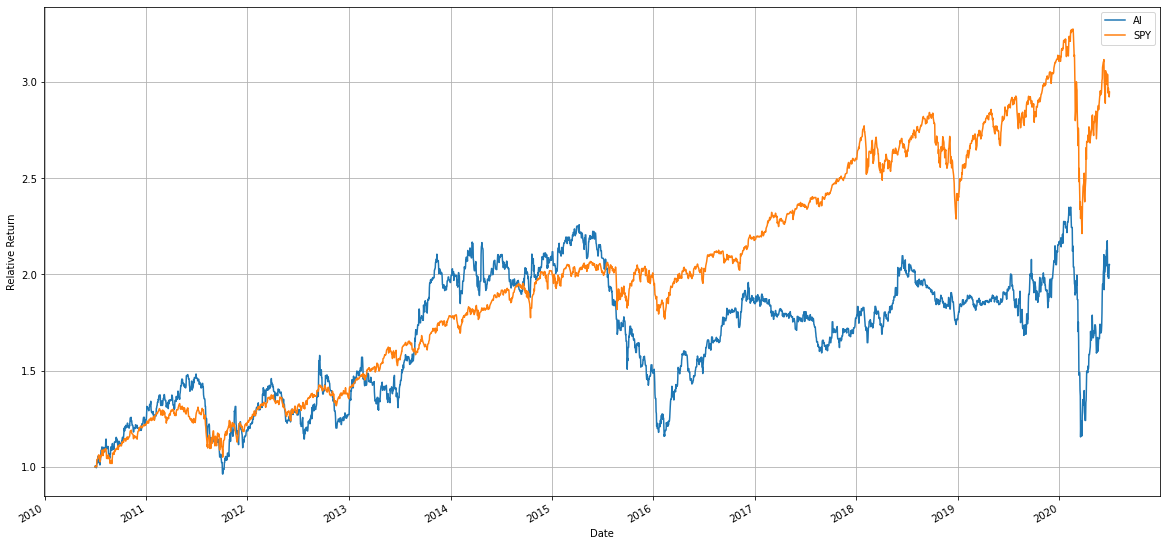

In [23]:
spy = dataForTicker('spy', portValOverTime.index[0], portValOverTime.index[-1]) # ISF.MI for FTSE 100
spy = getPortfolioRelativeTimeSeries(spy)
plt.figure(figsize=(20,10))
portValOverTime.plot()
spy['Open'].plot()
plt.legend(['AI','SPY'])
plt.ylabel('Relative Return')
plt.grid()

In [24]:
print(np.std(np.log(portValOverTime / portValOverTime.shift(-1))), np.std(np.log(spy['Open'] / spy['Open'].shift(-1))))

0.01304160693615576 0.01015398999403245


In [25]:
print(portValOverTime.iloc[-1], spy['Open'].iloc[-1])

2.0502201236880135 2.947067239335989


In [30]:
portValOverTime=annualBackTestMPT(randomState=42, numStocksInPortfolio=16, modelName='KNN', ETFExposure=True)

--------------------------------------------
Picked stocks from last 6M data for investment starting: 2010-07-01 , Ending: 2011-07-01
Using model:  KNN
      Stock  Individual Return %  Optimised Weight
0   JAKK.US                 32.2             0.049
1    HBP.US                -48.5             0.002
2    ODP.US                  NaN             0.000
3   RNWK.US                  NaN             0.000
4    JAN.US                 70.0             0.019
5    NLS.US                  NaN             0.000
6   NOVT.US                 65.6             0.017
7   RILY.US                -76.9             0.013
8    HUN.US                  NaN             0.000
9    AMN.US                 18.7             0.018
10  MTEX.US                  NaN             0.000
11  DXPE.US                 69.6             0.006
12    GT.US                  NaN             0.000
13  MERC.US                150.2             0.007
14   OSK.US                  8.2             0.014
15   IPI.US                 62.8

--------------------------------------------
Picked stocks from last 6M data for investment starting: 2017-07-01 , Ending: 2018-07-01
Using model:  KNN
       Stock  Individual Return %  Optimised Weight
0    FSTR.US                  5.8             0.011
1    DWSN.US                105.8             0.001
2     SAH.US                  4.6             0.023
3    QADB.US                 54.6             0.025
4    FLGT.US                -38.8             0.012
5     MTW.US                  7.0             0.027
6     BHC.US                  NaN             0.000
7     GPI.US                 -1.3             0.025
8    AEHL.US                 18.8             0.008
9    GORO.US                  NaN             0.000
10   CUTR.US                 57.7             0.040
11   KSPN.US                -45.6             0.026
12    THC.US                  NaN             0.000
13  OJSCY.US                 19.6             0.080
14    VHI.US                 59.5             0.003
15   SSNT.US    

# Do Many Runs to Compare With Standard Backtest

### Control Backtests. Annual, No MPT, No Gold/Bonds ETF Exposure

In [38]:
import os

# If the file already exists, add columns to the file
if os.path.exists('MPTBenchmarkRuns_NoMPT_NoETFs.csv'):
    portValRuns=pd.read_csv('MPTBenchmarkRuns_NoMPT_NoETFs.csv', index_col=0)
else:
    portValRuns = pd.DataFrame()

for i in range(20):
    print('Running backtest No. ', i)
    currentBackTest = annualBackTestMPT(randomState=i, numStocksInPortfolio=10,
                                        modelName='gradBoost',
                                        verbose=False, MPT=False, 
                                        ETFExposure=False)
    
    # If the file already exists, use the index from current DataFrame
    if os.path.exists('MPTBenchmarkRuns_NoMPT_NoETFs.csv'):
        currentBackTest.index = portValRuns.index
    
    portValRuns[i] = currentBackTest
    portValRuns.to_csv('MPTBenchmarkRuns_NoMPT_NoETFs.csv')

Running backtest No.  0
Running backtest No.  1
Running backtest No.  2
Running backtest No.  3
Running backtest No.  4
Running backtest No.  5
Running backtest No.  6
Running backtest No.  7
Running backtest No.  8
Running backtest No.  9
Running backtest No.  10
Running backtest No.  11
Running backtest No.  12
Running backtest No.  13
Running backtest No.  14
Running backtest No.  15
Running backtest No.  16
Running backtest No.  17
Running backtest No.  18
Running backtest No.  19


In [39]:
a = pd.read_csv('MPTBenchmarkRuns_NoMPT_NoETFs.csv',index_col=0)
a.iloc[-1].mean()

3.3824519449300494

### Annual, With MPT, No Gold/Bonds ETF Exposure

In [33]:
import os

# If the file already exists, add columns to the file
if os.path.exists('MPTBenchmarkRuns_MPT_NoETFs.csv'):
    portValRuns=pd.read_csv('MPTBenchmarkRuns_MPT_NoETFs.csv', index_col=0)
else:
    portValRuns = pd.DataFrame()

for i in range(20):
    print('Running backtest No. ', i)
    currentBackTest = annualBackTestMPT(randomState=i, numStocksInPortfolio=16,
                                        modelName='gradBoost',
                                        verbose=False, MPT=True, 
                                        ETFExposure=False)
    
    # If the file already exists, use the index from current DataFrame
    if os.path.exists('MPTBenchmarkRuns_MPT_NoETFs.csv'):
        currentBackTest.index = portValRuns.index
    
    portValRuns[i] = currentBackTest
    portValRuns.to_csv('MPTBenchmarkRuns_MPT_NoETFs.csv')

Running backtest No.  0
Running backtest No.  1
Running backtest No.  2
Running backtest No.  3
Running backtest No.  4
Running backtest No.  5
Running backtest No.  6
Running backtest No.  7
Running backtest No.  8
Running backtest No.  9
Running backtest No.  10
Running backtest No.  11
Running backtest No.  12
Running backtest No.  13
Running backtest No.  14
Running backtest No.  15
Running backtest No.  16
Running backtest No.  17
Running backtest No.  18
Running backtest No.  19
Running backtest No.  20
Running backtest No.  21
Running backtest No.  22
Running backtest No.  23
Running backtest No.  24
Running backtest No.  25
Running backtest No.  26
Running backtest No.  27
Running backtest No.  28
Running backtest No.  29


In [34]:
a = pd.read_csv('MPTBenchmarkRuns_MPT_NoETFs.csv', index_col=0)
a.iloc[-1].mean()

10.535622171533928

### Annual, With MPT, With Gold/Bonds ETF Exposure

In [35]:
import os

# If the file already exists, add columns to the file
if os.path.exists('MPTBenchmarkRuns_MPT_ETFs.csv'):
    portValRuns=pd.read_csv('MPTBenchmarkRuns_MPT_ETFs.csv', index_col=0)
else:
    portValRuns = pd.DataFrame()

for i in range(20):
    print('Running backtest No. ', i)
    currentBackTest = annualBackTestMPT(randomState=i, numStocksInPortfolio=16,
                                        modelName='gradBoost',
                                        verbose=False, MPT=True, 
                                        ETFExposure=True)
    
    # If the file already exists, use the index from current DataFrame
    if os.path.exists('MPTBenchmarkRuns_MPT_ETFs.csv'):
        currentBackTest.index = portValRuns.index
    
    portValRuns[i] = currentBackTest
    portValRuns.to_csv('MPTBenchmarkRuns_MPT_ETFs.csv')

Running backtest No.  0
Running backtest No.  1
Running backtest No.  2
Running backtest No.  3
Running backtest No.  4
Running backtest No.  5
Running backtest No.  6
Running backtest No.  7
Running backtest No.  8
Running backtest No.  9
Running backtest No.  10
Running backtest No.  11
Running backtest No.  12
Running backtest No.  13
Running backtest No.  14
Running backtest No.  15
Running backtest No.  16
Running backtest No.  17
Running backtest No.  18
Running backtest No.  19
Running backtest No.  20
Running backtest No.  21
Running backtest No.  22
Running backtest No.  23
Running backtest No.  24
Running backtest No.  25
Running backtest No.  26
Running backtest No.  27
Running backtest No.  28
Running backtest No.  29


In [36]:
a = pd.read_csv('MPTBenchmarkRuns_MPT_ETFs.csv', index_col=0)
a.iloc[-1].mean()

6.969633311027794